## Import

In [1]:
import os
import psycopg2
from dotenv import load_dotenv

import pandas as pd
import numpy as np

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.compose import make_column_selector as selector


# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

# Affichage cellule
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 1000)
from pprint import pprint

# Chargement du model pour déploiement
import pickle

## Connection à la DB sécurisé via des variables d'environnement

### création de la chaine de connexion

In [2]:


load_dotenv()  # Nécessaire pour charger les variables d'environnement précédemment définies

# Créer une connexion à postgres
connection = psycopg2.connect(host=os.environ.get('PG_HOST'),
                        user=os.environ.get('PG_USER'),
                        password=os.environ.get('PG_PASSWORD'),
                        dbname=os.environ.get('PG_DATABASE'))

connection.autocommit = True  # Assurez-vous que les données sont ajoutées à la base de données immédiatement après les commandes d'écriture.
cursor = connection.cursor()
cursor.execute('SELECT %s as connected;', ('Connection à postgres Réussie!',))
print(cursor.fetchone())

('Connection à postgres Réussie!',)


### Fonction de création du dataframe

In [3]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Transformer une requête SELECT en un dataframe pandas
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturellement, nous obtenons une liste de "tupples".
    tupples = cursor.fetchall()
    cursor.close()
    
    # Nous devons juste le transformer en dataframe pandas.
    df = pd.DataFrame(tupples, columns=column_names)
    return df

### Récupération de postgresql au dataframe

In [4]:
conn = connection
column_names = ["user_id","gender", "age", "height", "weight", "duration", "heart_rate", "body_temp", "calorie"]
# Execute the "SELECT *" query
df_db = postgresql_to_dataframe(conn, 
"SELECT persons.user_id as id, gender, age, height, weight, duration, heart_rate, body_temp,calorie FROM calories INNER JOIN persons ON calories.user_id = persons.user_id"
                                , column_names)
df_db.head()

,user_id,gender,age,height,weight,duration,heart_rate,body_temp,calorie
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [5]:
ohe=OneHotEncoder(sparse=False)

ct=make_column_transformer((ohe,['gender']))
data_ct=ct.fit_transform(df_db)

# Encodage sur le genre et retransformation en dataframe pandas nommé dum
ohe_True=OneHotEncoder(sparse=True)
ohe_with_sparse=ohe_True.fit_transform(df_db['gender'].values.reshape(-1,1)).toarray()
ohe_with_sparse

dum_scaler=pd.get_dummies(df_db,columns=['gender'],prefix='',prefix_sep='')

## Modele

In [ ]:
# # utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = dum_scaler.drop(['calorie','user_id'] , axis=1)
# y unidimensionnel
y = dum_scaler['calorie']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
def select_features(X_train, y_train, X_test, k_value='all'):
    fs = SelectKBest(score_func=chi2, k=k_value)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
# feature selection
X_train, X_test, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

In [ ]:
# what are scores for the features
names = []
values = []
for i in range(len(fs.scores_)):
    names.append(X.columns[i])
    values.append(fs.scores_[i])
chi_list = zip(names, values)

# plot the scores
plt.figure(figsize=(10,4))
sns.barplot(x=names, y=values)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
d = df_db[['duration', 'age', 'weight', 'calorie']]

In [ ]:
X = d.drop(['calorie'], axis=1)
y = d.calorie

In [ ]:
X.head(1)

In [ ]:
# split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# create a ml model using pipeline
model = make_pipeline(MinMaxScaler(), LinearRegression())
# fit the model on training data
model.fit(X_train, y_train)

In [ ]:
# test the model on test set
y_pred = model.predict(X_test)

# measure error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squre Error:", rmse)

In [ ]:
model.score(X_test, y_test)

In [ ]:
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))         # Finalize and render the figure

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [6]:
dataframe = df_db[['duration', 'age', 'height','weight', 'calorie']]

In [7]:
# We need to calculate IMC
dataframe['Height_meters'] = dataframe['height']/100
dataframe['calculated_IMC'] = (dataframe['weight']/dataframe['Height_meters']**2)

dataframe.head()

,duration,age,height,weight,calorie,Height_meters,calculated_IMC
0,29.0,68,190.0,94.0,231.0,1.90,26.038781
1,14.0,20,166.0,60.0,66.0,1.66,21.773842
2,5.0,69,179.0,79.0,26.0,1.79,24.655910
3,13.0,34,179.0,71.0,71.0,1.79,22.159109
4,10.0,27,154.0,58.0,35.0,1.54,24.456063


In [8]:
X = dataframe.drop(['height', 'weight', 'Height_meters','calorie'], axis=1)
y = dataframe.calorie

In [18]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape
X_test.shape, y_test.shape

((3000, 3), (3000,))

In [19]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

In [20]:
predictions = lm.predict(X_test)

Text(0, 0.5, 'Predictions')

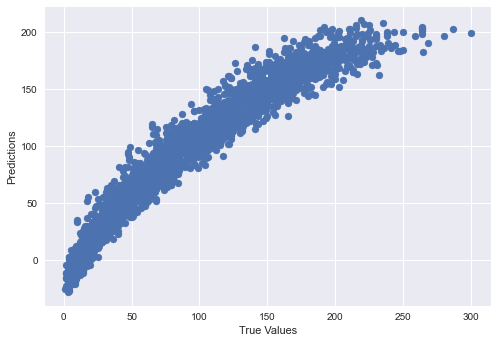

In [23]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [26]:
print('Score:', model.score(X_test, y_test))

Score: 0.930849839583665


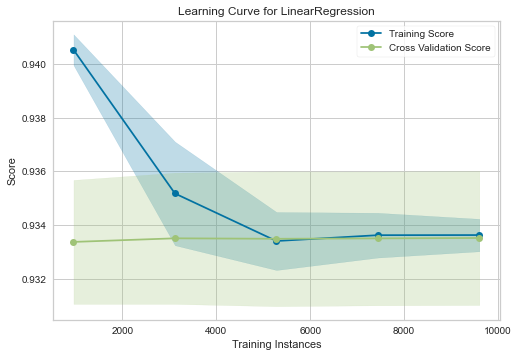

<AxesSubplot:title={'center':'Learning Curve for LinearRegression'}, xlabel='Training Instances', ylabel='Score'>

In [39]:
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(model, scoring='r2')
visualizer.fit(X_train, y_train)      
visualizer.show()          